# DeepDive Into GooglePlay Reviews

Previously, I had scrapped GooglePlay for user comments and reviews. I had classified the text as positive and negative based on user ratings. Now, I am going to do a deep dive into the review comments to see what aspects users comment on when they thing the game is good, and when they thing the game is bad. <br>
The methodologies used here include:
* LDA
* Ngrams
* Keyword in Context
* WordCloud

In [1]:
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.tokenize import RegexpTokenizer
import gensim
import nltk
import re
import string
stopset = set(stopwords.words('english'))


### Importing and Prepping Data 

In [2]:
pos = pd.read_csv("/Users/cherylto/Google Drive/Labs and Assignments/Web Scrapping/2018/pos.csv")
neg = pd.read_csv("/Users/cherylto/Google Drive/Labs and Assignments/Web Scrapping/2018/neg.csv")

In [3]:
pos, neg = pos['review_comments'], neg['review_comments']

### Topic Modelling

In [4]:
lemmatizer = WordNetLemmatizer()
def preprocess(document):
    words = document.lower()
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(words)
    filtered_words = ' '.join([w for w in tokens if not w in stopset])
    filtered_words = ''.join([i for i in filtered_words if not i.isdigit()])
    lemmas = lemmatizer.lemmatize(filtered_words)
    return ''.join(lemmas)

In [5]:
ppos = []
for i in range(len(pos)):
    p = preprocess(pos[i])
    t = word_tokenize(p)
    ppos.append(t)
    
    gen_docs = ppos
    dictionary = gensim.corpora.Dictionary(gen_docs)
    corpus = [dictionary.doc2bow(gen_doc) for gen_doc in gen_docs]

In [6]:
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = 5, id2word = dictionary, passes = 20)

In [7]:
print(ldamodel.print_topics(num_topics=5, num_words = 5))
#well that was completely useless, it seems like good games are just ... good!!!

[(0, '0.046*"game" + 0.012*"play" + 0.011*"like" + 0.011*"love" + 0.009*"fun"'), (1, '0.026*"game" + 0.011*"would" + 0.010*"like" + 0.009*"good" + 0.006*"play"'), (2, '0.048*"game" + 0.015*"like" + 0.013*"love" + 0.011*"play" + 0.011*"time"'), (3, '0.036*"game" + 0.014*"fun" + 0.011*"love" + 0.009*"play" + 0.009*"like"'), (4, '0.046*"å" + 0.037*"â" + 0.037*"game" + 0.025*"ë" + 0.024*"ä"')]


In [8]:
pneg = []
for i in range(len(neg)):
    p = preprocess(neg[i])
    t = word_tokenize(p)
    pneg.append(t)
    
    gen_docs = pneg
    dictionary = gensim.corpora.Dictionary(gen_docs)
    corpus = [dictionary.doc2bow(gen_doc) for gen_doc in gen_docs]

In [9]:
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = 5, id2word = dictionary, passes = 20)

In [10]:
print(ldamodel.print_topics(num_topics=5, num_words = 5))
#This is slightly more useful, we have words like ads, money. Let's see what else we can find using ngrams and word frequency

[(0, '0.021*"game" + 0.021*"å" + 0.019*"â" + 0.018*"ä" + 0.014*"ë"'), (1, '0.045*"game" + 0.015*"get" + 0.014*"ads" + 0.010*"play" + 0.010*"like"'), (2, '0.045*"game" + 0.013*"play" + 0.009*"good" + 0.009*"like" + 0.008*"really"'), (3, '0.040*"game" + 0.014*"get" + 0.011*"time" + 0.011*"play" + 0.011*"one"'), (4, '0.036*"game" + 0.032*"ads" + 0.016*"ad" + 0.015*"â" + 0.011*"like"')]


### Key Words

In [11]:
from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures
from nltk.corpus import stopwords
stopset = set(stopwords.words('english'))

In [12]:
#Adding a dictionary that will separate contractions.
CONTRACTION_MAP = {
"ain't": "is not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"I'd": "I would",
"I'd've": "I would have",
"I'll": "I will",
"I'll've": "I will have",
"I'm": "I am",
"I've": "I have",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"who've": "who have",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you would",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have"
}

In [13]:
def find_bigrams(unigrams):
    words = [w.lower() for w in unigrams]
    bcf = BigramCollocationFinder.from_words(words)
    filter_stops = lambda w: len(w) < 3 or w in stopset
    bcf.apply_freq_filter(5)
    bcf.apply_word_filter(filter_stops)
    bigrams = bcf.nbest(BigramAssocMeasures.likelihood_ratio, 20)
    return bigrams

In [14]:
from nltk.collocations import TrigramCollocationFinder
from nltk.metrics import TrigramAssocMeasures
def find_trigrams(unigrams):
    words = [w.lower() for w in unigrams]
    tcf = TrigramCollocationFinder.from_words(words)
    filter_stops = lambda w: len(w) < 3 or w in stopset
    tcf.apply_word_filter(filter_stops)
    tcf.apply_freq_filter(2)
    trigrams = tcf.nbest(TrigramAssocMeasures.likelihood_ratio, 20)
    return trigrams

In [15]:
pos_string = ' '.join(pos)
sent = sent_tokenize(pos_string)
nu_sent = []
for line in sent:
    for key, value in CONTRACTION_MAP.items():
        if key in line:
            line = line.replace(key, value)
    nu_sent.append(line)
    
pos_toks = word_tokenize(' '.join(nu_sent))


In [16]:
neg_string = ' '.join(neg)
sent = sent_tokenize(neg_string)
nu_sent = []
for line in sent:
    for key, value in CONTRACTION_MAP.items():
        if key in line:
            line = line.replace(key, value)
    nu_sent.append(line)

neg_toks = word_tokenize(' '.join(nu_sent))


In [17]:
pos_bi_grams = find_bigrams(pos_toks)
print("Positive bigrams:", pos_bi_grams)

Positive bigrams: [('great', 'game'), ('time', 'killer'), ('please', 'fix'), ('one', 'thing'), ('good', 'game'), ('well', 'done'), ('geometry', 'dash'), ('absolutely', 'love'), ('many', 'ads'), ('would', 'like'), ('big', 'fish'), ('ever', 'played'), ('game', 'ever'), ('even', 'though'), ('every', 'time'), ('stop', 'playing'), ('highly', 'recommend'), ('little', 'bit'), ('pretty', 'good'), ('every', 'single')]


In [18]:
pos_tri_grams = find_trigrams(pos_toks)
print("Positive trigrams:", pos_tri_grams)

Positive trigrams: [('overall', 'great', 'game'), ('anyway', 'great', 'game'), ('great', 'game', 'though'), ('really', 'great', 'game'), ('great', 'game', '...'), ('great', 'time', 'killer'), ('good', 'time', 'killer'), ('best', 'game', 'ever'), ('pretty', 'good', 'game'), ('really', 'good', 'game'), ('one', 'thing', 'though'), ('big', 'fish', 'casino'), ('job', 'well', 'done'), ('best', 'games', 'ever'), ('many', 'ads', 'though'), ('geometry', 'dash', 'games'), ('samsung', 'galaxy', 'tab'), ('would', 'highly', 'recommend'), ('est', 'game', 'ever'), ('worst', 'game', 'ever')]


In [20]:
neg_bi_grams = find_bigrams(neg_toks)
print("negative bi_grams:", neg_bi_grams)

negative bi_grams: [('many', 'ads'), ('please', 'fix'), ('cheap', 'cheap'), ('real', 'money'), ("n't", 'waste'), ('get', 'rid'), ('every', 'time'), ('good', 'game'), ('spend', 'money'), ('geometry', 'dash'), ('google', 'play'), ('free', 'spins'), ('new', 'update'), ('great', 'game'), ('last', 'update'), ('feels', 'like'), ('recent', 'update'), ('many', 'adds'), ('feel', 'like'), ('year', 'old')]


In [21]:
neg_tri_grams = find_trigrams(neg_toks)
print("negative tri_grams:", neg_tri_grams)

negative tri_grams: [('cheap', 'cheap', 'cheap'), ('sooooo', 'many', 'ads'), ('many', 'ads', 'like'), ('spend', 'real', 'money'), ('please', 'fix', 'it..'), ('spending', 'real', 'money'), ('really', 'good', 'game'), ('google', 'play', 'games'), ('like', 'google', 'play'), ('get', 'free', 'spins'), ('really', 'fun', 'game'), ('hill', 'climb', 'racing'), ('good', 'time', 'killer'), ('winter', 'butterfly', 'catch'), ('seems', 'like', 'everyone'), ('great', 'time', 'killer'), ('modern', 'strike', 'online'), ('front', 'facing', 'camera'), ('please', 'bring', 'back'), ('would', 'happily', 'pay')]


That's interesting, "really fun game" appears in the negative tri-grams. Let's look more closely using Keyword in Context.

### Keyword in Context

In [22]:
#KWIC
def kwic(words, text_to_search):
    length = len(words.split())
    
    for i, x in enumerate(text_to_search):
        phrase = ' '.join(text_to_search[i:i+length])
        if phrase.lower() == words:
            return ' '.join(text_to_search[i-10: i+10+length])
        
kwic('really good game', neg_toks)

'but Google will not let me. `` ) Was a really good game , but the latest updates have ruined it ! !'

In [23]:
re.findall('really good game', neg_string)

['really good game', 'really good game']

In [24]:
#Negative KWIC

word_string = []
kcontext = []

for i in range(len(neg_tri_grams)):
    w = re.sub("['(),]", '', str(neg_tri_grams[i]))
    text_to_search = neg_toks
    k = kwic(w, text_to_search)
    word_string.append(w)
    kcontext.append(k)
    print(w, "||", k)
    

cheap cheap cheap || one is necessary.CHEAP , CHEAP , CHEAP , CHEAP , CHEAP CHEAP CHEAP CHEAP CHEAP CHEAP CHEAP CHEAP CHEAP CHEAP CHEAP CHEAP CHEAP
sooooo many ads || . However , rated it a 3 cuz there are sooooo many ads . I get that ads generate the revenue to keep
many ads like || to ruin such a great game by packing in so many ads like this ? Its really sad : -/ ' ) The
spend real money || of characters to earn and you do not need to spend real money to get them , so that is a plus .
please fix it.. || I play . Is the Auto save work properly ? PLEASE FIX IT.. PLEASE ! ! ! ! ! ! ! `` )
spending real money || million chips from me after playing for 9 months and spending real money on this game . They will not respond to emails
really good game || but Google will not let me. `` ) Was a really good game , but the latest updates have ruined it ! !
google play games || Why bother putting the work in again ? ' ) Google play games has a worse version . Once signed into google play
like goo

In [25]:
#Positive KWIC

word_string = []
kcontext = []

for i in range(len(pos_tri_grams)):
    w = re.sub("['(),]", '', str(pos_tri_grams[i]))
    text_to_search = pos_toks
    k = kwic(w, text_to_search)
    word_string.append(w)
    kcontext.append(k)
    print(w, "||", k)

overall great game || matter how ( or am i a noob ? ) Overall great game ( its free ) if u enjoy it slow and
anyway great game || Could go through 100 and 123,000 for 1 minute . Anyway great game if you liked my review go onto Episode to see
great game though || for a lot of things are extraordinarily high . Overall great game though five stars ! ' ) Addictive , amazing game with
really great game || I am going to absolutely enjoy this game. `` ) Really great game this is a msg to the designer 's of the
great game ... || I think they skip paying but overall it is a great game ... .THANKS . Ca n't say enuf first game I really
great time killer || and the words are not too hard , its a great time killer and its fun usually I do not like these kind
good time killer || park boys as much as I do : D very good time killer `` ) Far too many ads that take too long
best game ever || ÄÅ¸ÅÅ¸ÄÅ¸ÅÅ¸ÄÅ¸ÅÅ¸ÄÅ¸ÅÅ¸ÄÅ¸ÅÅ¸ `` ) OMG look at this game loved it best game ever my favorite car is th

In [26]:
from subprocess import check_output
from wordcloud import WordCloud, STOPWORDS
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

### WordCloud for positive Reviews

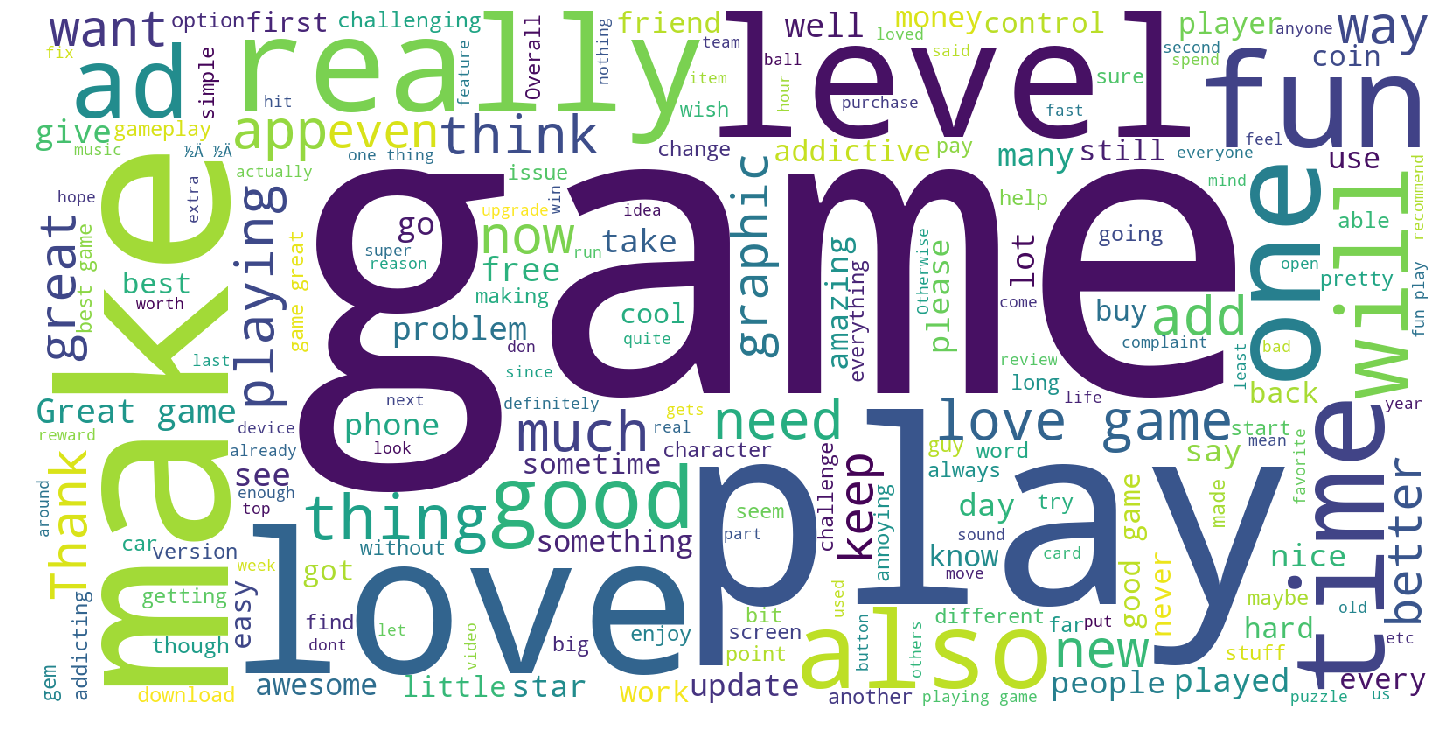

In [27]:
data = pos_string
wordcloud = WordCloud(background_color="white", width=1600, height = 800).generate(data)
plt.figure( figsize=(20,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

### WordCloud for Negative Reviews

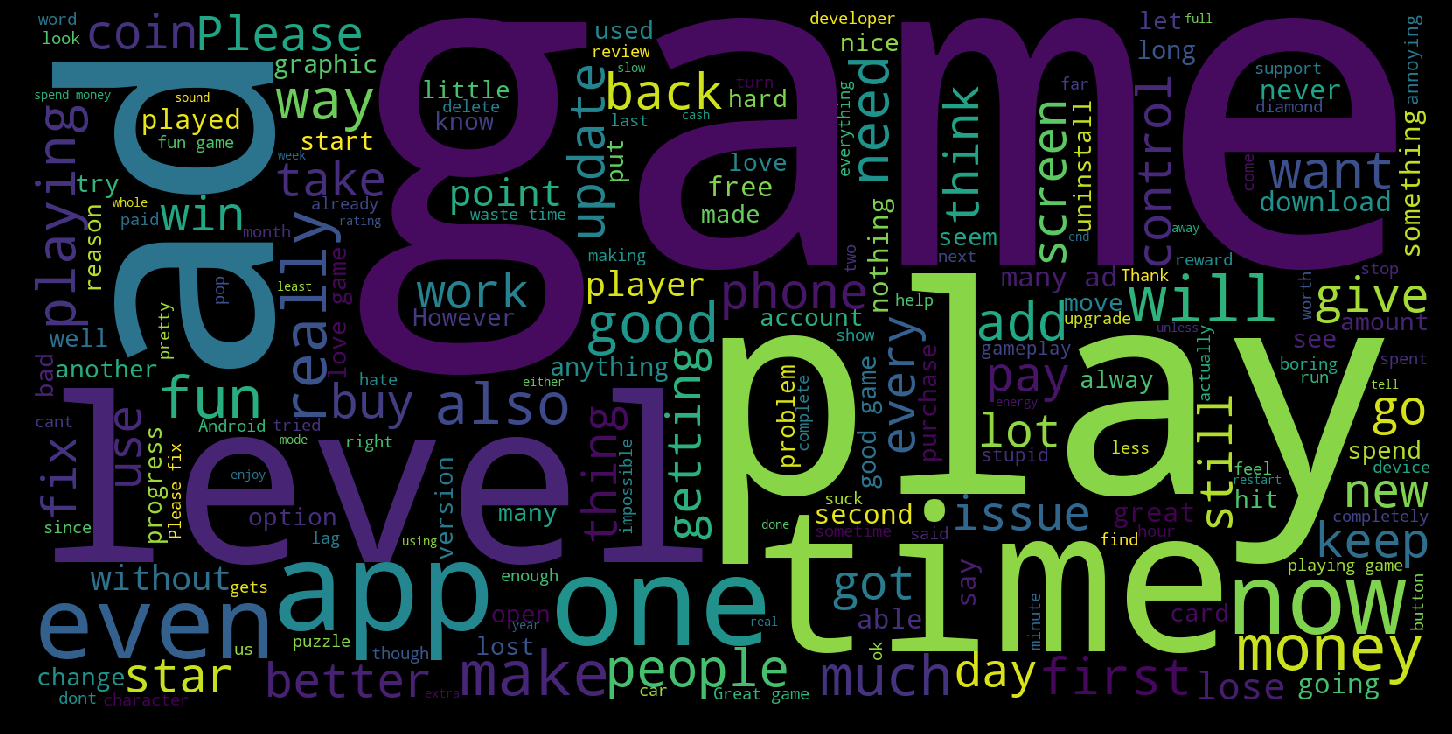

In [28]:
data = neg_string

wordcloud = WordCloud(width=1600, height = 800).generate(data)
plt.figure( figsize=(20,10), facecolor='k')
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

It is perhaps understandable that "game" and "play" are the most frequent words. However, the two word clouds can be distinguished by  words such as "money", "update", "support", "please fix", "waste time" in the negative cloud, and "love", "free", "fun", "great", "addicting". In general, then, update issues, bugs, and lack of support tend to lead to lower star review ratings. <br>
Next steps: <br>
* correct spelling before analysing; this will reduce duplicates in ngrams ("soooo" = "so)
* improve the kwic function to return all matches of pattern in text